In [1]:
#Import dependancies
import tensorflow as tf
from transformers import TFGPT2LMHeadModel, GPT2Tokenizer
from sklearn.utils import shuffle
import pandas as pd
import numpy as np
tokenizer = GPT2Tokenizer.from_pretrained('gpt2') #Encoder text to tensor
model = TFGPT2LMHeadModel.from_pretrained('gpt2', pad_token_id=tokenizer.eos_token_id) 

c:\Users\Christian Gauthier\miniconda3\envs\tf\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [2]:
#Get Yelp dataset and normalize 
reviews = pd.read_csv('bigreviews.csv')
#reviews = shuffle(reviews) remove shuffle

#normalize
for column in reviews:
    reviews['text'] = reviews['text'].str.lower()   #Covert the text to lower case
    reviews['text'].str.replace('[^\w\s]','') #Remove punctuation
    reviews['text'].str.strip() #Remove whitespace
    reviews['text'].str.replace("\n", " ") #Remove escape characters
reviews = reviews['text']

print(reviews)

C:\Users\Christian Gauthier\AppData\Local\Temp\ipykernel_30676\3859494564.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  reviews['text'].str.replace('[^\w\s]','') #Remove punctuation


0         if you decide to eat here, just be aware it is...
1         i've taken a lot of spin classes over the year...
2         family diner. had the buffet. eclectic assortm...
3         wow!  yummy, different,  delicious.   our favo...
4         cute interior and owner (?) gave us tour of up...
                                ...                        
499995    we won the playoff game last night and is sche...
499996    we have been a resident almost 4 years at manz...
499997    this place is hyped as one of the best places ...
499998    saw the reviews so thought i'd try this place....
499999    yummy!  i ordered uber eats and wasn't sure ho...
Name: text, Length: 500000, dtype: object


In [3]:
#Segment the first section for model
df1 = reviews[:35000]

C:\Users\Christian Gauthier\AppData\Local\Temp\ipykernel_25368\214069651.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  df1 = reviews[:35000]


**Method**
From attempts to run the model as a whole, have had issues trying to run the large model and save weights due to the time to run epochs along with saving the dataframe, in attempt will train large model in chunks of 35k at a time and run the model using saved weights


Trying to get model to work initially, issues with getting the model to accurately predict the last tokens from the input on larger 50k scale. Model accuracy is growing at a very slow rate between epoch, trying new medium sized gpt2 models with 35k and removing optimizer. 35k ----> 25k

Next, trying to go large model, using 50k chunks, implement back optimizer

Scrap all that, using initial iteration, lower amount of review samples being passed (35k), using 12 batch size 100 block, will move on shifts of 35k every 20 or so epoch

In [3]:
#turn the entire reviews set into a long string to be segmented in next sequence
def stringify_tokenize(dataframe):
  single_string = ''
  for row in dataframe:
    x = row
    single_string += x 
  string_tokenized = tokenizer.encode(single_string)
  return string_tokenized

SyntaxError: invalid syntax (1913439883.py, line 7)

In [9]:
def datasetCreate(string_tokenized):
  # Define variables to store the data
  examples = []
  block_size = 100 
  BATCH_SIZE = 12 
  BUFFER_SIZE = 1000
  # Split the string_tokenized list into blocks of size block_size
  # and store each block in the examples list
  for i in range(0, len(string_tokenized) - block_size + 1, block_size):
    examples.append(string_tokenized[i:i + block_size])

  # Initialize empty lists for inputs and labels
  inputs, labels = [], [] 

  # For each example in the examples list,
  # store input as the example without the last element
  # store the label as the example without the first element
  for ex in examples:
    inputs.append(ex[:-1])
    labels.append(ex[1:])

  # Create a dataset from the inputs and labels tensors
  dataset = tf.data.Dataset.from_tensor_slices((inputs, labels))

  # Shuffle the dataset and batch it
  dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
  return dataset

In [6]:
# defining optimizer
opt = tf.keras.optimizers.Adam(learning_rate=3e-5)#not in use 
# definining loss function
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# defining our metric which we want to observe
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
# compiling the model
model.compile(loss=[loss],optimizer='adam',metrics=[metric])

In [11]:
checkpoint_filepath = 'tmp/weights.{epoch:02d}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='accuracy',
    mode='auto',
    save_best_only=True)

In [8]:
history = model.fit(dataset,epochs=15,callbacks=[model_checkpoint_callback])

Epoch 1/15
3788/3788 [==============================] - 760s 198ms/step - loss: 3.8791 - accuracy: 0.2836
Epoch 2/15
3788/3788 [==============================] - 735s 194ms/step - loss: 3.5623 - accuracy: 0.3096
Epoch 3/15
3788/3788 [==============================] - 722s 191ms/step - loss: 3.3303 - accuracy: 0.3304
Epoch 4/15
3788/3788 [==============================] - 709s 187ms/step - loss: 3.1144 - accuracy: 0.3521
Epoch 5/15
3788/3788 [==============================] - 693s 183ms/step - loss: 2.9103 - accuracy: 0.3755
Epoch 6/15
3788/3788 [==============================] - 693s 183ms/step - loss: 2.7203 - accuracy: 0.3993
Epoch 7/15
3788/3788 [==============================] - 693s 183ms/step - loss: 2.5455 - accuracy: 0.4232
Epoch 8/15
3788/3788 [==============================] - 695s 183ms/step - loss: 2.3855 - accuracy: 0.4463
Epoch 9/15
3788/3788 [==============================] - 693s 183ms/step - loss: 2.2386 - accuracy: 0.4690
Epoch 10/15
3788/3788 [=======================

**Check Resuls**

In [8]:
import matplotlib.pyplot as plt

#plot of the accuracy
def plot_acc():
    history_dict = history.history
    history_dict.keys() # the data gathered during training
    plt.clf()
    acc = history_dict['accuracy']
    epochs = range(1, len(acc) + 1)
    solid_blue_line = 'b'
    blue_dots = 'bo'

    plt.plot(epochs, acc, solid_blue_line, label = 'Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

#plot of the loss
def plot_loss():
    history_dict = history.history
    history_dict.keys()
    loss = history_dict['loss']
    epochs = range(1, len(loss) + 1)
    solid_blue_line = 'b'
    blue_dots = 'bo'

    plt.plot(epochs, loss, solid_blue_line, label = 'Training loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [ ]:
plot_acc()
plot_loss()
early_stopping_epoch = np.argmax(history.history["accuracy"])+1
print(early_stopping_epoch)

Smooth Graphs, lets keep going

In [13]:
history = model.fit(dataset,epochs=15,callbacks=[model_checkpoint_callback])

Epoch 1/15
3788/3788 [==============================] - 873s 230ms/step - loss: 1.4904 - accuracy: 0.6032
Epoch 2/15
3788/3788 [==============================] - 1030s 272ms/step - loss: 1.4131 - accuracy: 0.6187
Epoch 3/15
3788/3788 [==============================] - 719s 190ms/step - loss: 1.3421 - accuracy: 0.6337
Epoch 4/15
3788/3788 [==============================] - 698s 184ms/step - loss: 1.2749 - accuracy: 0.6479
Epoch 5/15
3788/3788 [==============================] - 687s 181ms/step - loss: 1.2142 - accuracy: 0.6618
Epoch 6/15
3788/3788 [==============================] - 680s 179ms/step - loss: 1.1568 - accuracy: 0.6745
Epoch 7/15
3788/3788 [==============================] - 699s 184ms/step - loss: 1.1032 - accuracy: 0.6869
Epoch 8/15
3788/3788 [==============================] - 687s 181ms/step - loss: 1.0537 - accuracy: 0.6986
Epoch 9/15
3788/3788 [==============================] - 708s 187ms/step - loss: 1.0079 - accuracy: 0.7094
Epoch 10/15
3788/3788 [======================

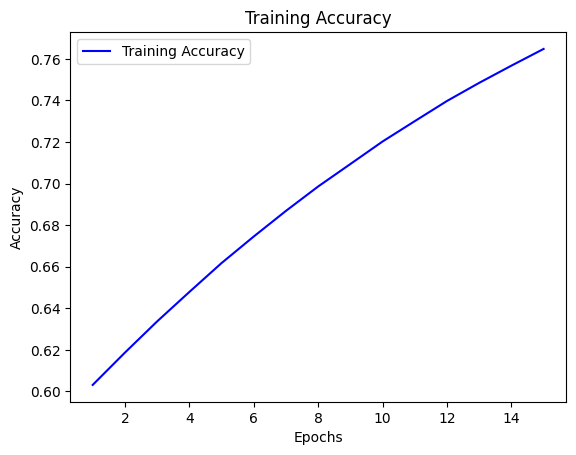

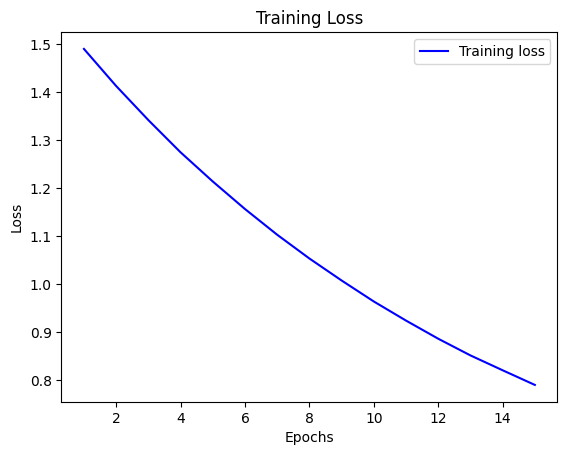

15


In [15]:
plot_acc()
plot_loss()
early_stopping_epoch = np.argmax(history.history["accuracy"])+1
print(early_stopping_epoch)

**Reload model with saved weights**

*Train on next segment of dataset*

In [14]:
text = "i found"
# encoding the input text
input_ids = tokenizer.encode(text, return_tensors='tf')
# getting out output
output = model.generate(
  input_ids,
  max_length = 150,
  num_beams = 5,
  temperature = 0.75,
  no_repeat_ngram_size=2,
  num_return_sequences=5
)

print(tokenizer.decode(output[0]))

i found the staff to be very friendly and helpful.  

i was in and out in less than an hour. they were able to get me in right away. i will definitely use them again.i have been here twice and both times were excellent. the food is delicious and the service is top-notch. if you're looking for a quick bite to eat, this is the place for you.this place is awesome! i came here with a group of friends and we nothing nothing like like nothing extra like such like extra nothing spot like, like spot nothing special nothing friendly nothing such nothing, extra extra spot friendly like other nothing while like friendly, nothing. nothing t like. like special like t nothing house extra such such


In [3]:
#Segment the second section for model
df2 = reviews[35000:70000]

C:\Users\Christian Gauthier\AppData\Local\Temp\ipykernel_25544\1975816305.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  df2 = reviews[35000:70000]


In [4]:
single_string = ''
for row in df2:
  x = row
  single_string += x 
string_tokenized = tokenizer.encode(single_string)

Token indices sequence length is longer than the specified maximum sequence length for this model (4517633 > 1024). Running this sequence through the model will result in indexing errors


In [7]:
dataset = datasetCreate(string_tokenized)

In [6]:
# defining optimizer
opt = tf.keras.optimizers.Adam(learning_rate=3e-5)#not in use 
# definining loss function
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# defining our metric which we want to observe
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
# compiling the model
model.compile(loss=[loss],optimizer='adam',metrics=[metric])

In [14]:
model.load_weights('tmp\weights.15.h5')
model.summary()

Model: "tfgpt2lm_head_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer (TFGPT2MainLaye  multiple                 124439808 
 r)                                                              
                                                                 
Total params: 124,439,808
Trainable params: 124,439,808
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(dataset,epochs=15,callbacks=[model_checkpoint_callback])

Epoch 1/15
3764/3764 [==============================] - 719s 188ms/step - loss: 3.7258 - accuracy: 0.3080
Epoch 2/15
3764/3764 [==============================] - 675s 179ms/step - loss: 3.3376 - accuracy: 0.3418
Epoch 3/15
3764/3764 [==============================] - 673s 179ms/step - loss: 3.0312 - accuracy: 0.3741
Epoch 4/15
3764/3764 [==============================] - 704s 187ms/step - loss: 2.7532 - accuracy: 0.4067
Epoch 5/15
3764/3764 [==============================] - 705s 187ms/step - loss: 2.5063 - accuracy: 0.4393
Epoch 6/15
3764/3764 [==============================] - 704s 187ms/step - loss: 2.2924 - accuracy: 0.4696
Epoch 7/15
3764/3764 [==============================] - 688s 183ms/step - loss: 2.1104 - accuracy: 0.4977
Epoch 8/15
3764/3764 [==============================] - 687s 183ms/step - loss: 1.9526 - accuracy: 0.5232
Epoch 9/15
3764/3764 [==============================] - 698s 185ms/step - loss: 1.8165 - accuracy: 0.5464
Epoch 10/15
3764/3764 [=======================

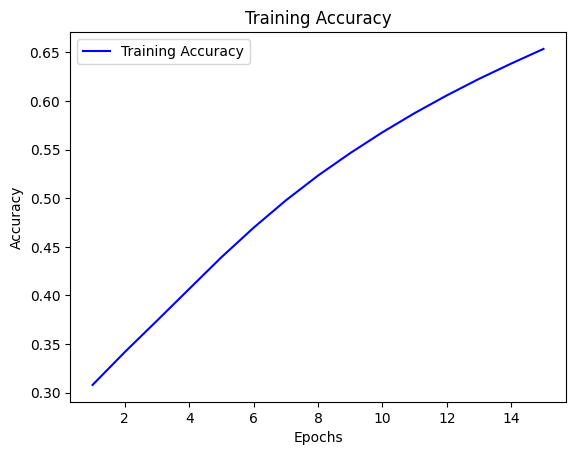

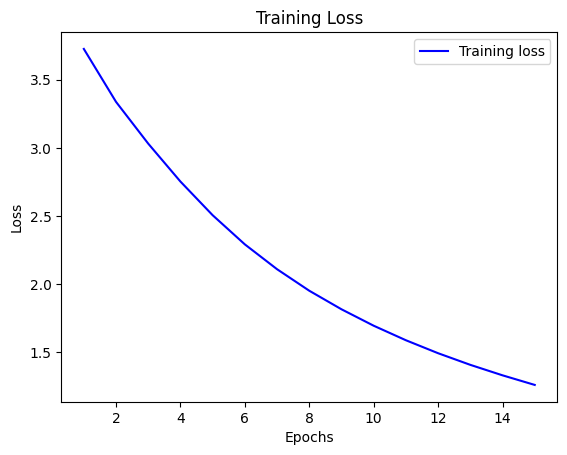

15


In [18]:
plot_acc()
plot_loss()
early_stopping_epoch = np.argmax(history.history["accuracy"])+1
print(early_stopping_epoch)

In [19]:
history = model.fit(dataset,epochs=15,callbacks=[model_checkpoint_callback])

Epoch 1/15
3764/3764 [==============================] - 688s 183ms/step - loss: 1.1983 - accuracy: 0.6672
Epoch 2/15
3764/3764 [==============================] - 696s 185ms/step - loss: 1.1406 - accuracy: 0.6802
Epoch 3/15
3764/3764 [==============================] - 758s 201ms/step - loss: 1.0864 - accuracy: 0.6926
Epoch 4/15
3764/3764 [==============================] - 788s 209ms/step - loss: 1.0382 - accuracy: 0.7035
Epoch 5/15
3764/3764 [==============================] - 723s 192ms/step - loss: 0.9922 - accuracy: 0.7143
Epoch 6/15
3764/3764 [==============================] - 677s 180ms/step - loss: 0.9511 - accuracy: 0.7245
Epoch 7/15
3764/3764 [==============================] - 674s 179ms/step - loss: 0.9123 - accuracy: 0.7338
Epoch 8/15
3764/3764 [==============================] - 675s 179ms/step - loss: 0.8770 - accuracy: 0.7428
Epoch 9/15
3764/3764 [==============================] - 674s 179ms/step - loss: 0.8440 - accuracy: 0.7514
Epoch 10/15
3764/3764 [=======================

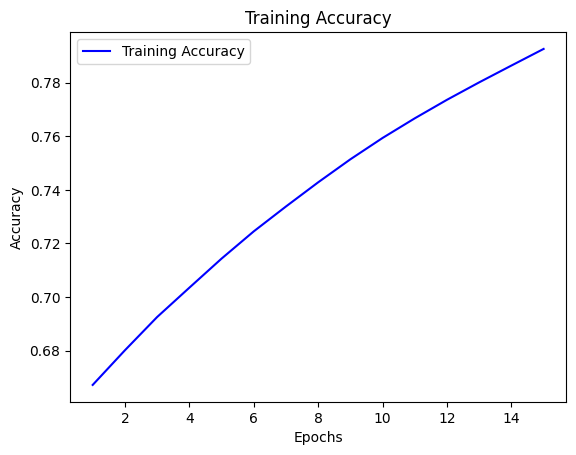

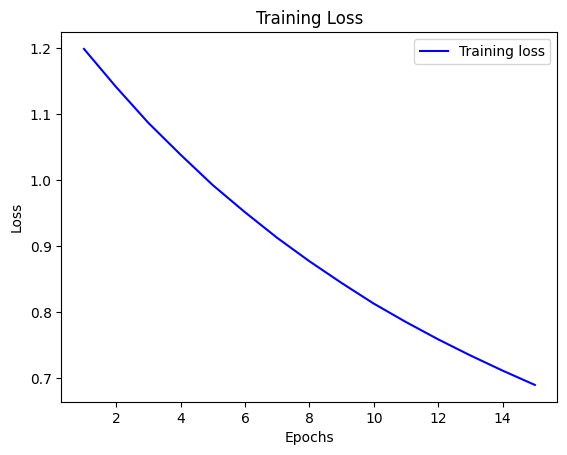

15


In [20]:
plot_acc()
plot_loss()
early_stopping_epoch = np.argmax(history.history["accuracy"])+1
print(early_stopping_epoch)

In [22]:
text = "i found"
# encoding the input text
input_ids = tokenizer.encode(text, return_tensors='tf')
# getting out output
output = model.generate(
  input_ids,
  max_length = 150,
  num_beams = 5,
  temperature = 0.85,
  no_repeat_ngram_size=2,
  num_return_sequences=5
)

print(tokenizer.decode(output[0]))

i found them to be professional, honest and honest. i had a great experience with them due to my insurance company emergency issues. they replaced a set of keys, problem corrected problem, and my wife's car was ready for pick up in 2 hours when promised. great deal! i highly recommend.i have been going to the men's room since it opened and each time i am not disappointed.  the food is a-maze-ing! and the cookies! wow, are this good a party in my new or bad one?  now gone now that i must have gone!

twice cream of my favorite restaurant again! :/enjoyedges are we are out of so many great foodies in nashville


*Third Segment*

In [5]:
#Segment the third section for model
df3 = reviews[70000:105000]
single_string = ''
for row in df3:
  x = row
  single_string += x 
string_tokenized = tokenizer.encode(single_string)

Token indices sequence length is longer than the specified maximum sequence length for this model (4491353 > 1024). Running this sequence through the model will result in indexing errors


In [10]:
dataset = datasetCreate(string_tokenized)

In [12]:
# defining optimizer
opt = tf.keras.optimizers.Adam(learning_rate=3e-5)#not in use 
# definining loss function
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# defining our metric which we want to observe
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
# compiling the model
model.compile(loss=[loss],optimizer='adam',metrics=[metric])
model.load_weights('tmp\weights.15.h5')

In [14]:
history = model.fit(dataset,epochs=30,callbacks=[model_checkpoint_callback])

Epoch 1/30
3742/3742 [==============================] - 698s 184ms/step - loss: 3.6800 - accuracy: 0.3135
Epoch 2/30
3742/3742 [==============================] - 662s 177ms/step - loss: 3.3156 - accuracy: 0.3466
Epoch 3/30
3742/3742 [==============================] - 659s 176ms/step - loss: 3.0318 - accuracy: 0.3770
Epoch 4/30
3742/3742 [==============================] - 659s 176ms/step - loss: 2.7701 - accuracy: 0.4081
Epoch 5/30
3742/3742 [==============================] - 751s 201ms/step - loss: 2.5321 - accuracy: 0.4394
Epoch 6/30
3742/3742 [==============================] - 755s 202ms/step - loss: 2.3200 - accuracy: 0.4693
Epoch 7/30
3742/3742 [==============================] - 703s 188ms/step - loss: 2.1349 - accuracy: 0.4975
Epoch 8/30
3742/3742 [==============================] - 664s 177ms/step - loss: 1.9731 - accuracy: 0.5233
Epoch 9/30
3742/3742 [==============================] - 674s 180ms/step - loss: 1.8325 - accuracy: 0.5468
Epoch 10/30
3742/3742 [=======================

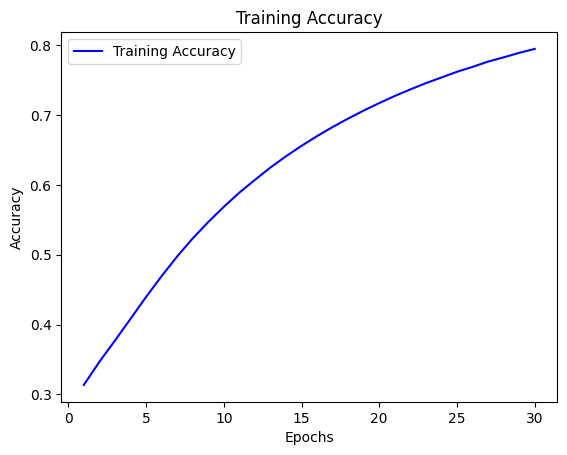

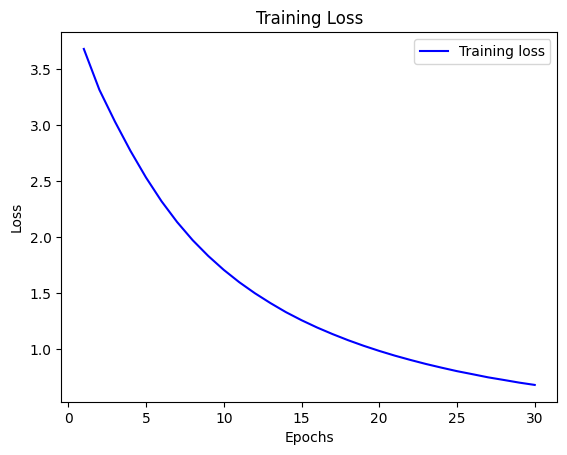

30


In [15]:
plot_acc()
plot_loss()
early_stopping_epoch = np.argmax(history.history["accuracy"])+1
print(early_stopping_epoch)

In [23]:
text = "this place"
# encoding the input text
input_ids = tokenizer.encode(text, return_tensors='tf')
# getting out output
output = model.generate(
  input_ids,
  max_length = 200,
  num_beams = 5,
  temperature = 0.75,
  no_repeat_ngram_size=2,
  num_return_sequences=5
)
outputed = tokenizer.decode(output[0])

outputed.strip() #Remove whitespace
outputed.replace("\n", " ") #Remove escape characters
print(outputed)

this place is perfect!  even better migas than i've had in austin.  great rhythm to the place. must be owned by a drummer.

worth the wait, if you miss this place there will be trouble, boys.(this review is for the food only, not the music venues)
i've only been here once for lunch, but it was pretty crowded when i was there for dinner, the space is smaller than the dining room appears from the outside, and the indoor and i didn't know it looked at all the outdoor seating really liked the lighting was really clean that cause we were dressed up against the back ribs. my eyes, so that was just there were a toned open booths and there wasn't too bad seats a stagecozy inside. outside. service was a lot of the atmosphere, just a crunchy up close to gooey seats at first. inside and just enjoying the cool spot. friendly attentive, it did takeout dining space.


*Fourth Segment*